In [2]:
# hydrological packages
import hydroeval as he
from hydrotools.nwm_client import utils

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# system packages
from progressbar import ProgressBar
from datetime import datetime, date
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time

# data analysi packages
from scipy import optimize
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#Shared/Utility scripts
import sys
import boto3
import s3fs
import os
sys.path.insert(0, '..') #sys allows for the .ipynb file to connect to the shared folder files

#load access key
HOME = os.path.expanduser('~')
KEYPATH = "NWM_ML/AWSaccessKeys.csv"
ACCESS = pd.read_csv(f"{HOME}/{KEYPATH}")

#start session
SESSION = boto3.Session(
    aws_access_key_id=ACCESS['Access key ID'][0],
    aws_secret_access_key=ACCESS['Secret access key'][0],
)
S3 = SESSION.resource('s3')
#AWS BUCKET information
BUCKET_NAME = 'streamflow-app-data'
BUCKET = S3.Bucket(BUCKET_NAME)

#s3fs
fs = s3fs.S3FileSystem(anon=False, key=ACCESS['Access key ID'][0], secret=ACCESS['Secret access key'][0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
#Get streamstats data 
datapath = f"{HOME}/NWM_ML/Data/input"
file = "Streamstats.csv"
filepath = f"{datapath}/{file}"
try:
    StreamStats = pd.read_csv(filepath)
except:
    print("Data not found, retreiving from AWS S3")
    if not os.path.exists(datapath):
        os.makedirs(datapath, exist_ok=True)
    key = 'Streamstats/Streamstats.csv'      
    S3.meta.client.download_file(BUCKET_NAME, key,filepath)
    StreamStats = pd.read_csv(filepath)

#Get processed training data 
datapath = f"{HOME}/NWM_ML/Data/Processed"
file = "raw_training_data.parquet"
filepath = f"{datapath}/{file}"
try:
    raw_training_data = pd.read_parquet(filepath)
except:
    print("Data not found, retreiving from AWS S3")
    if not os.path.exists(datapath):
        os.makedirs(datapath, exist_ok=True)
    key = "NWM_ML"+datapath.split("NWM_ML",1)[1]+'/'+file       
    S3.meta.client.download_file(BUCKET_NAME, key,filepath)
    raw_training_data = pd.read_parquet(filepath)

raw_training_data.pop('Unnamed: 0')
raw_training_data['station_id'] = raw_training_data['station_id'].astype('str')
raw_training_data.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,Mean_Ann_Precip_in,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,34.8,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305


In [10]:
Training_DF = raw_training_data.copy()

### Editing the features based on the feature importance should be in the next cell!!!!!!!!!!!!!!!

In [11]:
# Editing the features based on the feature importance should be done here!!!!!!!!!!!!!!!

Training_DF.drop(['precipitation_in', 'temperature_F', 'Mean_Ann_Precip_in', 'Perc_Herbace', 'Perc_Forest',
                        'Mean_Basin_Elev_ft'], axis=1, inplace=True)



### Remove headwater stations!!!!!!!

In [12]:
headwater_stations = ['10011500', '10109000', '10113500', '10128500', '10131000', '10146400', '10150500', '10154200',
'10172700', '10172800', '10172952']
Training_DF = Training_DF[~raw_training_data['station_id'].isin(headwater_stations)]

In [13]:
Training_DF.datetime = pd.to_datetime(Training_DF.datetime)

Training_DF.head()


,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
789,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-01,1488.4375,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-02,1282.1875,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-03,1269.4791,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-04,1551.5625,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2012-03-05,1490.5209,0.515038,0.857167,89.026144,13.221429,1541.0,65


In [14]:
x_train_temp = Training_DF[Training_DF.datetime.dt.year != 2020]
x_train_temp.pop('station_id')
x_train_temp.pop('datetime')
y_train_temp = x_train_temp['flow_cfs']
x_train_temp.pop('flow_cfs')
x_train_temp.head()

,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,s1,s2,storage,swe,NWM_flow,DOY
789,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,85.588235,12.778571,1542.0,61
790,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,86.712418,13.085714,1542.0,62
791,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,87.359477,13.178571,1542.0,63
792,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,88.163399,13.221429,1541.0,64
793,41.576321,-112.100782,7040.0,4.28,0.55,1.94,0.515038,0.857167,89.026144,13.221429,1541.0,65


In [15]:

y_train = y_train_temp.to_numpy()

x_train = x_train_temp.to_numpy()

scaler = MinMaxScaler()


x_train_scaled = scaler.fit_transform(x_train)

y_scaled_train = scaler.fit_transform(y_train.reshape(-1, 1))


In [16]:
y_scaled_train.shape

(24069, 1)

In [17]:
x_test_temp = Training_DF[Training_DF.datetime.dt.year == 2020]
x_test_temp.head()

,station_id,Lat,Long,Drainage_area_mi2,Perc_Develop,Perc_Imperv,Perc_Slop_30,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY
1029,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-01,1642.3959,0.515038,0.857167,64.241830,14.914286,1012.0,61
1030,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-02,1724.2709,0.515038,0.857167,64.215686,15.142857,1011.0,62
1031,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-03,1751.2500,0.515038,0.857167,64.189542,15.135714,1010.0,63
1032,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-04,1675.4166,0.515038,0.857167,64.189542,15.135714,1009.0,64
1033,10126000,41.576321,-112.100782,7040.0,4.28,0.55,1.94,2020-03-05,1697.8125,0.515038,0.857167,64.241830,15.085714,1008.0,65


In [18]:
x_test_temp_1 = x_test_temp.copy()
station_index_list = x_test_temp_1['station_id']
x_test_temp_1.pop('station_id')
x_test_temp_1.pop('datetime')
y_test_temp_1 = x_test_temp_1['flow_cfs']
x_test_temp_1.pop('flow_cfs')
x_test_1_np = x_test_temp_1.reset_index(drop=True).to_numpy()
y_test_1_np = y_test_temp_1.reset_index(drop=True).to_numpy()
x_test_1_scaled = scaler.fit_transform(x_test_1_np)
y_scaled_test_1 = scaler.fit_transform(y_test_1_np.reshape(-1, 1))

In [19]:
# %% LSTM

n_targets = 1

tries = 10


cri_temp_nse = np.zeros([3, n_targets, tries])

cri_temp_rmse = np.zeros([3, n_targets, tries])

cri_temp_r2 = np.zeros([3, n_targets, tries])

cri_temp_kge = np.zeros([3, n_targets, tries])

cri_temp_lognse = np.zeros([3, n_targets, tries])


#remove first column
#Training_DF.pop('Unnamed: 0')

#Split the data into features and target
#y = Training_DF['flow_cfs'].to_numpy()

#remove target from features
#Training_DF.pop('flow_cfs')

#x = Training_DF.to_numpy()

'''The DataFrame looks good, now lets scale the data.
XGBoost does not require this but others do and it is a good housekeeping step.
'''



# split data into train and test sets
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

#x_scaled = scaler.fit_transform(x)

#y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(x_scaled, y_scaled, test_size=0.33, random_state=1)

print('finish')


finish


In [20]:
# Reshape Input for LSTM Model
x_train_scaled_test = torch.Tensor(x_train_scaled).unsqueeze(1)
y_train_scaled_test = torch.Tensor(y_scaled_train).unsqueeze(1)




In [21]:
x_test_1_scaled.shape

(2466, 12)

In [22]:
y_train_scaled_test.shape

torch.Size([24069, 1, 1])

In [23]:
x_train_scaled_test = x_train_scaled_test.to(device)
y_train_scaled_test = y_train_scaled_test.to(device)

In [24]:
start_time = time.time()
import datetime

# Assuming you have your data loaded into NumPy arrays as x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, x_scaled, y_scaled



# Hyperparameters
epochs = 50
batch_size = 50
learning_rate = 0.0001
decay = 1e-2
validation_split = 0.2
neurons = 300

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(x_train_scaled_test, y_train_scaled_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Build the model
model = nn.LSTM(input_size=x_train_scaled_test.shape[2], hidden_size=neurons, bidirectional=True, batch_first=True).to(device)
fc = nn.Linear(neurons * 2, 1).to(device)  # Multiply by 2 for bidirectional LSTM

# Define loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay) #

# Training loop
for epoch in range(epochs):
    model.train()
    fc.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        

        output, _ = model(batch_x)
        output = fc(output[:, -1, :])
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

print('finish')
print("Run Time:" + " %s minutes " % ((time.time() - start_time)/60))
#save model
torch.save(model.state_dict(), f"./lstm_models/lstm_model.pkl")

Epoch 1/50, Loss: 0.024089223660670678
Epoch 2/50, Loss: 0.023174987186012835
Epoch 3/50, Loss: 0.022759778878591902
Epoch 4/50, Loss: 0.02275974834459801
Epoch 5/50, Loss: 0.02273156438801168
Epoch 6/50, Loss: 0.022642849673660998
Epoch 7/50, Loss: 0.02265940518401026
Epoch 8/50, Loss: 0.022516118571148578
Epoch 9/50, Loss: 0.022440119099826697
Epoch 10/50, Loss: 0.022565160684389712
Epoch 11/50, Loss: 0.022495468192566207
Epoch 12/50, Loss: 0.02246560864063575
Epoch 13/50, Loss: 0.022373632432545604
Epoch 14/50, Loss: 0.022318958455896685
Epoch 15/50, Loss: 0.022485240592456546
Epoch 16/50, Loss: 0.022441114790322687
Epoch 17/50, Loss: 0.022389504494776134
Epoch 18/50, Loss: 0.022397496238246047
Epoch 19/50, Loss: 0.02240464922994244
Epoch 20/50, Loss: 0.022386874264749577
Epoch 21/50, Loss: 0.022437682516091066
Epoch 22/50, Loss: 0.022410198345469288
Epoch 23/50, Loss: 0.022425213499785462
Epoch 24/50, Loss: 0.02231541121591929
Epoch 25/50, Loss: 0.022355729849350685
Epoch 26/50, Lo

In [27]:

#put the model scores into a dataframe for comparison
mod = 'LSTM'
cols = ['USGSid', 'NHDPlusid', 'NWM_rmse', f"{mod}_rmse", 'NWM_pbias', f"{mod}_pbias", 'NWM_kge', f"{mod}__kge", 'NWM_mape',  f"{mod}_mape"]EvalDF = pd.DataFrame(columns = cols )

SitesDict = {}
#Load model
model.load_state_dict(torch.load(f"./lstm_models/lstm_model.pkl"))

for station_number in station_index_list.drop_duplicates():
    device = torch.device('cuda')
    x_train_scaled_test = x_train_scaled_test.to(device)

    model = model.to(device)
    fc = fc.to(device)
    #print(station_number)
    index = station_index_list == station_number


    X_test = x_test_temp_1[index]

    X_test_scaled = torch.Tensor(x_test_1_scaled[index]).unsqueeze(1).to(device)
    y_test = y_test_temp_1[index]
    # Evaluation
    model.eval()
    with torch.no_grad():
        yhat_train, _ = model(x_train_scaled_test)

        yhat_train = fc(yhat_train[:, -1, :])
        yhat_test, _ = model(X_test_scaled)
        yhat_test = fc(yhat_test[:, -1, :])

    # Invert scaling for actual
    device = torch.device('cpu')
    yhat_train = yhat_train.to(device)
    yhat_test = yhat_test.to(device)
    
    inv_yhat_train = scaler.inverse_transform(yhat_train.numpy())
    inv_yhat_test = scaler.inverse_transform(yhat_test.numpy())

    inv_yhat_test[inv_yhat_test<0] = 0

    #print('finish')
    # %%

    #nwm_lstm = np.concatenate((inv_yhat_train, inv_yhat_test), axis=0)

    nwm_test = pd.DataFrame(inv_yhat_test, columns=['LSTM_flow'])

    Dfs = [nwm_test.reset_index(drop=True), x_test_temp_1[index].reset_index(drop=True), y_test.reset_index(drop=True)]


 #make daterange
    dates = pd.date_range(pd.to_datetime("2020-01-01"), periods=len(nwm_test)).strftime("%Y-%m-%d").tolist()
    nwm_test['Datetime'] = dates
    #put columns in correct order
    cols = ['Datetime', 'LSTM_flow']
    nwm_test = nwm_test[cols]
    
    #get reach id for model eval
    nhdreach = utils.crosswalk(usgs_site_codes=station_number)
    nhdreach = nhdreach['nwm_feature_id'].iloc[0]
    
    #save predictions
    mod = 'LSTM'
    save_path = f"./Predictions/Hindcast/{mod}/{mod}_{nhdreach}.csv"
    nwm_test.to_csv(save_path)
    
      # merge
    Eval_DF_mine = pd.concat(Dfs, axis=1)
    prediction_columns = [ 'NWM_flow', 'LSTM_flow']

    #plot the predictions
   # Model_Evaluation_Plots(Eval_DF_mine, prediction_columns)

    #Get RMSE from the model
    rmse = RMSE(Eval_DF_mine, prediction_columns)

    #Get Mean Absolute Percentage Error from the model
    mape = MAPE(Eval_DF_mine, prediction_columns)

    #Get Percent Bias from the model
    pbias = PBias(Eval_DF_mine, prediction_columns)

    #Get Kling-Gutz Efficiency from the model
    kge = KGE(Eval_DF_mine, prediction_columns)
    
    #save model performance
    sitestats = [station_number, nhdreach, rmse[0], rmse[1],  pbias[0], pbias[1], kge[0], kge[1], mape[0],  mape[1]]
    EvalDF.loc[len(EvalDF)] = sitestats
    
    #put prediction DF into dictionary
    Eval_DF_mine.sort_values(by=['DOY'], inplace=True)
    Eval_DF_mine['Datetime'] = pd.to_datetime(dates)
    Eval_DF_mine.set_index('Datetime', inplace = True)
    SitesDict[nhdreach] = Eval_DF_mine
    
    
EvalDF   
   

,USGSid,NHDPlusid,NWM_rmse,MLP_rmse,NWM_pbias,MLP_pbias,NWM_kge,MLP__kge,NWM_mape,MLP__mape
0,10126000,4605050,2004.216242,1314.167366,-75.45,86.30,-0.71,-0.77,368.22,70.45
1,10130500,10092262,274.011248,138.459360,-102.82,81.95,-1.34,-0.40,220.10,75.66
2,10134500,10277268,141.565303,81.481339,-160.24,98.75,-1.01,-0.78,393.93,97.81
3,10136500,10274616,669.746563,311.024611,-183.78,84.01,-1.33,-0.29,285.84,75.96
4,10137500,10274270,66.070097,113.462171,28.12,85.23,0.33,-0.26,29.53,82.90
5,10141000,10273232,1176.666054,259.678891,-471.48,83.28,-4.13,-0.71,1141.47,65.59
6,10155000,10373622,417.242696,610.302133,30.12,87.53,0.26,-0.37,193.64,60.72
7,10164500,10329013,156.897354,32.882812,-205.18,49.48,-3.78,0.02,110.94,53.67
8,10171000,10390290,3387.369919,102.923927,-2260.76,63.97,-22.90,-0.29,2549.80,62.01


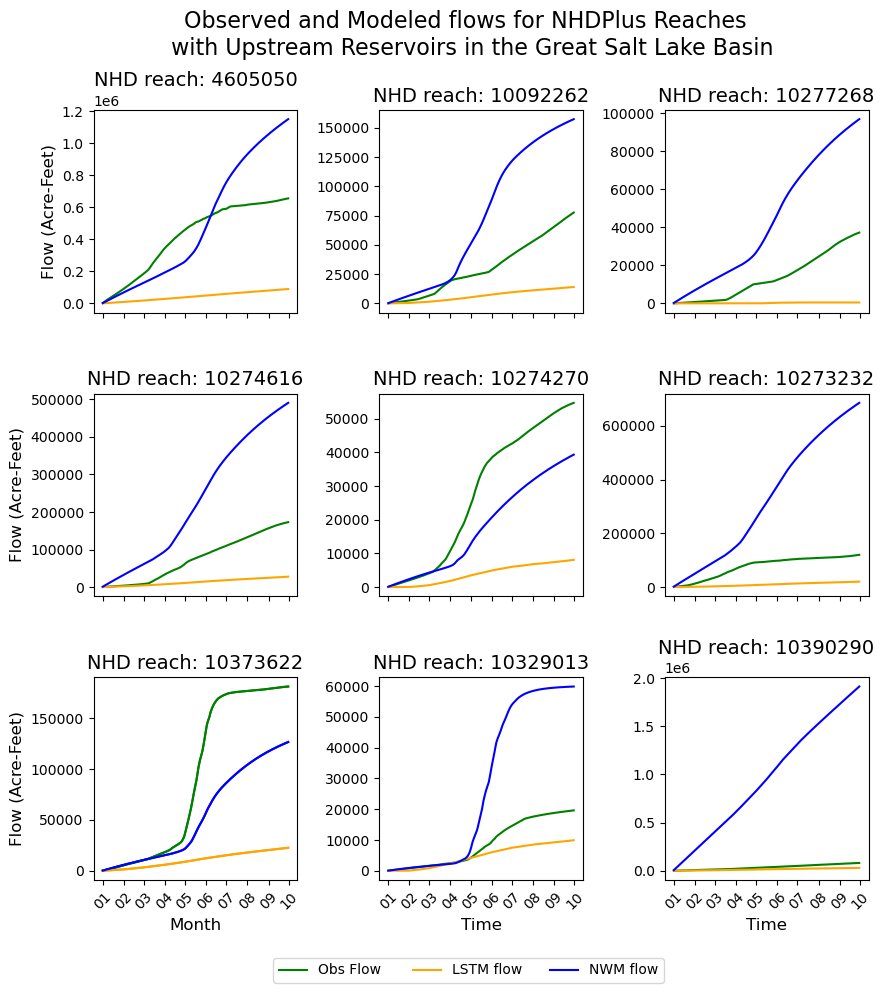

In [31]:
model = 'LSTM'
plotname = 'LSTM_TS_plot'
freq = 'D'
supply = True
title = 'Observed and Modeled flows for NHDPlus Reaches \n with Upstream Reservoirs in the Great Salt Lake Basin'
FigureGenerator.TS_plot(SitesDict, model, plotname, title, freq, supply)

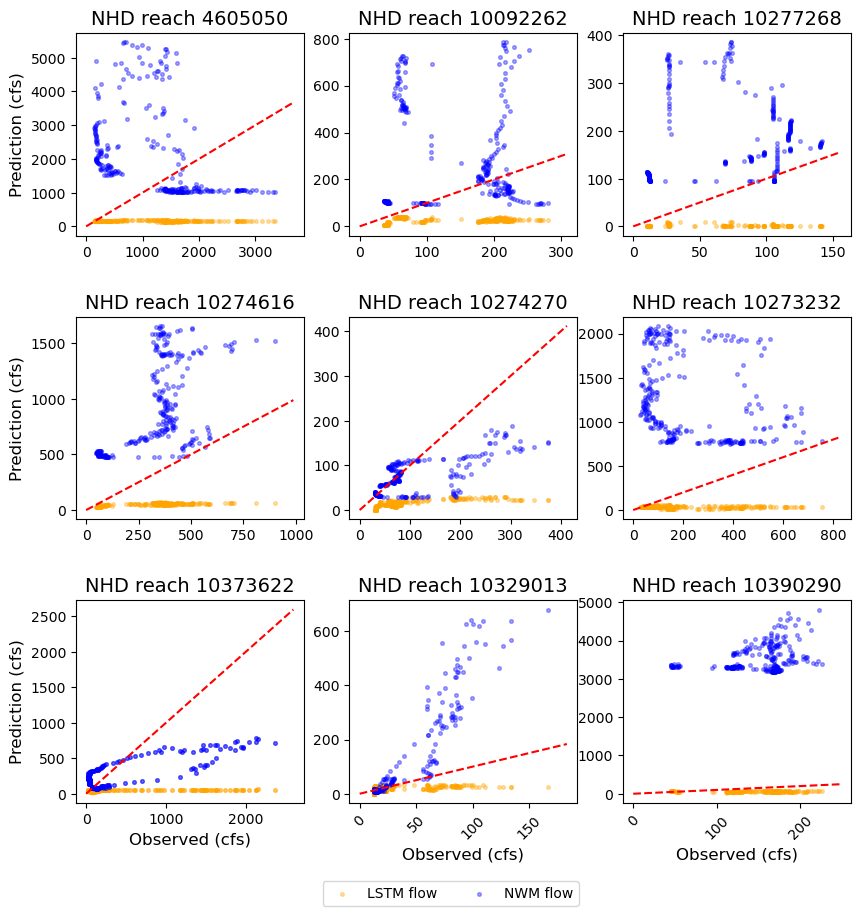

In [29]:
plotname = 'LSTM_ParityPlot'
FigureGenerator.Parity_plot(SitesDict, model, plotname)

In [33]:
import AWS_transfer
model = 'LSTM'
AWS_transfer.Predictions2AWS(model)

Pushing files to AWS


100% |########################################################################|
